In [153]:
import torch
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from chirho.robust.internals.utils import ParamDict

pyro.settings.set(module_local_params=True)
sns.set_style("white")
pyro.set_rng_seed(321)  # for reproducibility

In [154]:
class ToyNormal(pyro.nn.PyroModule):
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=sd),
        )


class ToyNormalKnownSD(pyro.nn.PyroModule):
    def __init__(self, sd_true):
        super().__init__()
        self.sd_true = sd_true
    def forward(self):
        mu = pyro.sample("mu", dist.Normal(0.0, 1.0))
        sd = pyro.sample("sd", dist.HalfNormal(1.0))
        return pyro.sample(
            "Y",
            dist.Normal(mu, scale=self.sd_true),
        )

class GroundTruthToyNormal(pyro.nn.PyroModule):
    def __init__(self, mu_true, sd_true):
        super().__init__()
        self.mu_true = mu_true
        self.sd_true = sd_true
    def forward(self):
        return pyro.sample(
            "Y",
            dist.Normal(self.mu_true, scale=self.sd_true),
        )

In [155]:
normal_pdf = lambda x, mu, sd: torch.exp(-0.5 * ((x - mu) / sd) ** 2) / (sd * math.sqrt(2.0 * math.pi))
normal_pdf_partial_sd = torch.func.grad(normal_pdf, argnums=2)


def fisher_eif_analytic(Y, mu, sd, known_sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    if known_sd:
        return torch.zeros(Y.shape[0])
    else:
        sd_torch = torch.tensor(sd, requires_grad=True)
        z_monte = sd * torch.randn(10000) + mu
        grad_functional = 2 * torch.tensor([normal_pdf_partial_sd(z, mu, sd_torch) for z in z_monte]).mean()
        inverse_fisher = sd ** 2 / 2
        score = ((Y - mu) ** 2) / (sd ** 3) - 1/sd
    return grad_functional * inverse_fisher * score


def kennedy_if_analytic(Y, mu, sd):
    assert isinstance(mu, float)
    assert isinstance(sd, float)
    pdf_at_y = normal_pdf(Y, mu, sd)
    z_monte = sd * torch.randn(100000)
    expected_density = torch.tensor([normal_pdf(z, mu, sd) for z in z_monte]).mean()
    return 2 * (pdf_at_y - expected_density)

# Analytic Influence Function & Efficient Influence Function

In [156]:
N_pts = 500
mu_true = 0.0
sd_true = 1.0
true_model = GroundTruthToyNormal(mu_true, sd_true)
D_pts = Predictive(true_model, num_samples=N_pts, return_sites=["Y"])()
Y_pts = D_pts["Y"]
Y_pts = torch.sort(Y_pts).values

fisher_pointwise = fisher_eif_analytic(Y_pts, mu_true, sd_true, False)
kennedy_pointwise = kennedy_if_analytic(Y_pts, mu_true, sd_true)
tangent_fn_pointwise = kennedy_pointwise - fisher_pointwise

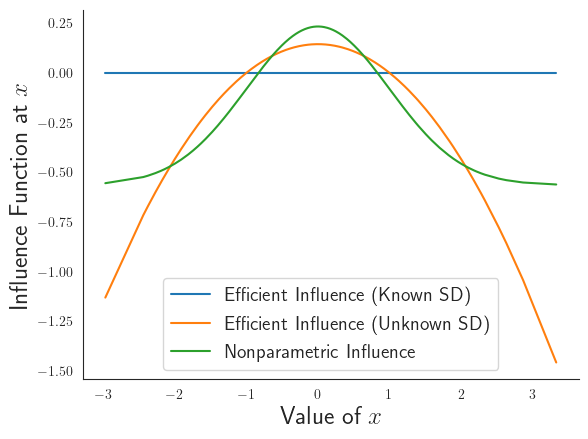

In [157]:
plt.rcParams['text.usetex'] = True
plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label="Efficient Influence (Known SD)")
plt.plot(Y_pts, fisher_pointwise, label="Efficient Influence (Unknown SD)")
plt.plot(Y_pts, kennedy_pointwise, label="Nonparametric Influence")
# plt.plot(Y_pts, tangent_fn_pointwise, label="Tangent Nuisance Function")
plt.xlabel('Value of $x$', fontsize=18)
plt.ylabel('Influence Function at $x$', fontsize=18)
plt.legend(fontsize=14)
sns.despine()
plt.savefig("figures/toy_normal_influence_functions.pdf")

In [158]:
# This should be close to zero since the tangent nuisance function 
# is orthogonal to the efficient influence function
fisher_pointwise.dot(tangent_fn_pointwise) / N_pts

tensor(0.0004)

# Compare Analytic w/ Automated Influnce Functions

In [159]:
import functools
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood

In [160]:
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )
            
class ExpectedDensity(torch.nn.Module):
    def __init__(self, model, *, num_monte_carlo: int = 10000):
        super().__init__()
        self.model = model
        self.log_marginal_prob = BatchedNMCLogMarginalLikelihood(model, num_samples=1)
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", self.num_monte_carlo):
            points = PredictiveFunctional(self.model)(*args, **kwargs)

        log_marginal_prob_at_points = self.log_marginal_prob(points, *args, **kwargs)
        return torch.exp(
            torch.logsumexp(log_marginal_prob_at_points, dim=0)
            - math.log(self.num_monte_carlo)
        )

In [161]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True), 
    "sd": torch.tensor(sd_true, requires_grad=True)
}

model = ToyNormal()
guide = MLEGuide(theta_true)

monte_eif = influence_fn(
    functional, {'Y': Y_pts}, num_samples_outer=50000, num_samples_inner=1
)(PredictiveModel(model, guide))()

## Uknown Mean, Unknown SD

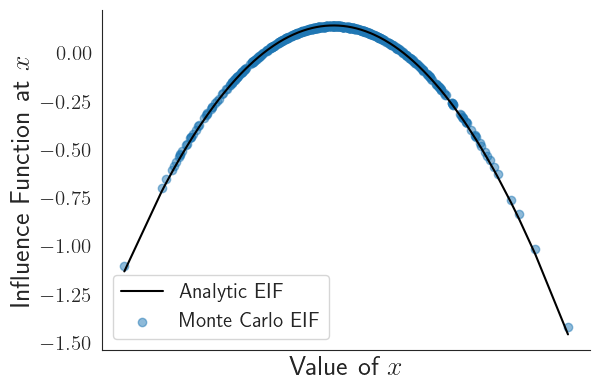

In [162]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Y_pts, fisher_pointwise, label='Analytic EIF', color='black')
plt.scatter(Y_pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.xlabel('Value of $x$', fontsize=20)
plt.xticks([])
plt.ylabel('Influence Function at $x$', fontsize=20)
plt.legend(fontsize=15)
sns.despine()
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.savefig("figures/toy_normal_monte_carlo_eif_unknown_var.pdf")

## Uknown Mean, Known SD

In [144]:
functional = functools.partial(ExpectedDensity, num_monte_carlo=10000)

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True), 
}

model = ToyNormalKnownSD(sd_true)
guide = MLEGuide(theta_true)

monte_eif = influence_fn(
    functional, {'Y': Y_pts}, num_samples_outer=50000, num_samples_inner=1
)(PredictiveModel(model, guide))()

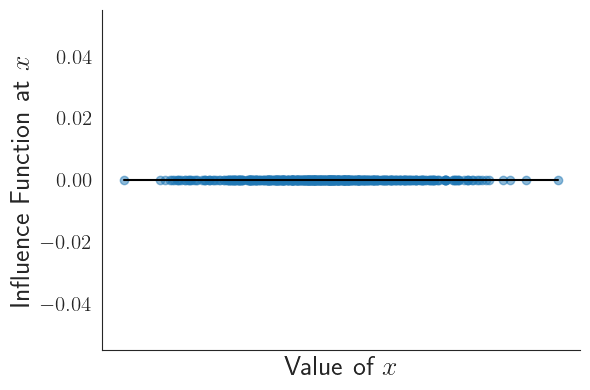

In [150]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Y_pts, torch.zeros(Y_pts.shape[0]), label='Analytic EIF', color='black')
plt.scatter(Y_pts, monte_eif.detach().numpy(), label='Monte Carlo EIF', alpha=.5)
plt.xlabel('Value of $x$', fontsize=20)
plt.xticks([])
plt.ylabel('Influence Function at $x$', fontsize=20)
# plt.legend(fontsize=13)
sns.despine()
plt.tick_params(axis='y', labelsize=15)
plt.tight_layout()
plt.savefig("figures/toy_normal_monte_carlo_eif_known_var.pdf")

# Finite-Difference Smoothed Gateaux Approach

In [15]:
import sys
sys.path.append("../scripts/")
from fd_influence_approx import (
    compute_fd_correction_sqd_mvn_mc,
    compute_fd_correction_sqd_mvn_quad
)

In [21]:
import os
import pickle

theta_true = {
    "mu": torch.tensor(mu_true, requires_grad=True).unsqueeze(0), 
    "scale_tril": torch.tensor(sd_true, requires_grad=True).unsqueeze(0)
}

fd_quad_kwargs = {
    "lambdas": [.1, .001, .00001],
    "epss": [.1, .001, .00001],
    "num_samples_scaling": 10,
    "seed": 0,
}

RESULT_PATH = "results/toy_normal_fd_quad_eif_results.pkl"

if os.path.exists(RESULT_PATH):
    fd_quad_eif_results = pickle.load(open(RESULT_PATH, "rb"))
else:
    fd_quad_eif_results = compute_fd_correction_sqd_mvn_quad(
        theta_hat=theta_true,
        test_data={'x': Y_pts.unsqueeze(-1)},
        **fd_quad_kwargs
    )

    pickle.dump(fd_quad_eif_results, open(RESULT_PATH, "wb"))

In [67]:
def to_latex_scientific_notation(num):
    """
    Convert a float to a string in LaTeX-style scientific notation (e.g., 10^{-2}).

    Args:
    num (float): The number to convert.

    Returns:
    str: The number in LaTeX-style scientific notation as a string.
    """
    if num == 0:
        return '0'
    else:
        exponent = int(math.floor(math.log10(abs(num))))
        base = num / (10 ** exponent)
        if base == 1:
            return f'10^{{{exponent}}}'
        else:
            return f'{base:.1f} \\times 10^{{{exponent}}}'

In [68]:
to_latex_scientific_notation(.001)

'10^{-3}'

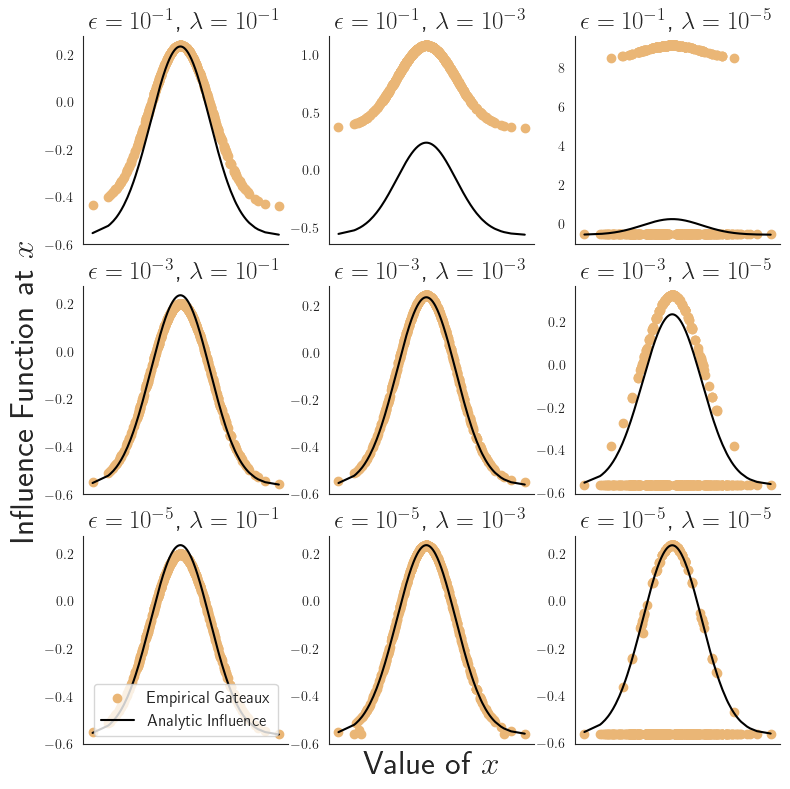

In [114]:
# Plot 3 x 3 grid of results
fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True)
for iter, result in enumerate(fd_quad_eif_results):
        i = iter // 3
        j = iter % 3
        epsilon = fd_quad_kwargs["epss"][i]
        lam = fd_quad_kwargs["lambdas"][j]
        axes[i, j].scatter(Y_pts, result['pointwise'], label='Empirical Gateaux', color='#eab676')
        axes[i, j].plot(Y_pts, kennedy_pointwise, label='Analytic Influence', color='black')
        if i==2 and j==1:
                axes[i, j].set_xlabel('Value of $x$', fontsize=24)
        if j==0 and i==1:
                axes[i, j].set_ylabel('Influence Function at $x$', fontsize=24)
        axes[i, j].set_title(f"$\epsilon={to_latex_scientific_notation(epsilon)}$, $\lambda={to_latex_scientific_notation(lam)}$", fontsize=18)            
        sns.despine()
        axes[i,j].tick_params(axis='y', labelsize=10)
axes[2, 0].legend(fontsize=12)
plt.xticks([])


plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2) 
plt.savefig("./figures/expected_density_gateaux_grid.png")

# Runtime vs. Quality

In [23]:
def median_rel_error(x, y):
    x = torch.tensor(x)
    y = torch.tensor(y)
    return torch.median(torch.abs(x - y) / torch.abs(y))

fd_quad_rel_mae = [median_rel_error(result['pointwise'], kennedy_pointwise) for result in fd_quad_eif_results]
fd_quad_time = [result['wall_time'] for result in fd_quad_eif_results]

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_32431/3498049407.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


In [30]:
monte_eif_size = []
monte_eif_errors = []
monte_eif_runtimes = []
for n_monte in [10, 100, 1000, 10000, 100000]:
    start = time.time()
    functional = functools.partial(ExpectedDensity, num_monte_carlo=n_monte)
    theta_true = {
        "mu": torch.tensor(mu_true, requires_grad=True), 
        "sd": torch.tensor(sd_true, requires_grad=True)
    }

    model = ToyNormal()
    guide = MLEGuide(theta_true)
    monte_eif = influence_fn(
        functional, {'Y': Y_pts}, num_samples_outer=n_monte, num_samples_inner=1
    )(PredictiveModel(model, guide))()
    end = time.time()
    monte_eif_runtimes.append(end - start)
    monte_eif_errors.append(median_rel_error(monte_eif, fisher_pointwise))
    monte_eif_size.append(n_monte)


/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_32431/3498049407.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_32431/3498049407.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


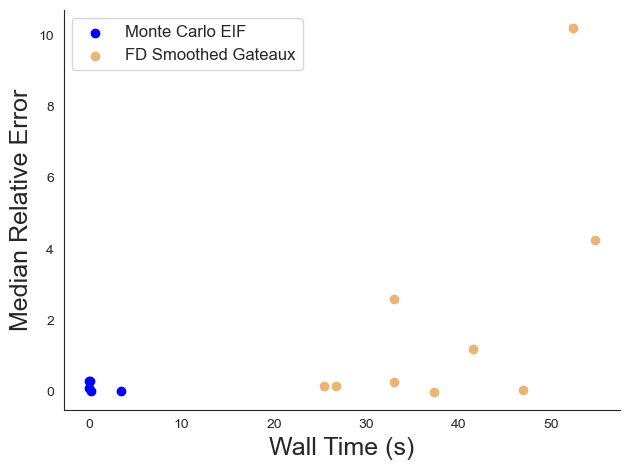

In [31]:
plt.scatter(monte_eif_runtimes, monte_eif_errors, label='Monte Carlo EIF', color='blue')
plt.scatter(fd_quad_time, fd_quad_rel_mae, label='FD Smoothed Gateaux', color='#eab676')
plt.xlabel('Wall Time (s)', fontsize=18)
plt.ylabel('Median Relative Error', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')
plt.legend(fontsize=12)
sns.despine()
plt.tight_layout()

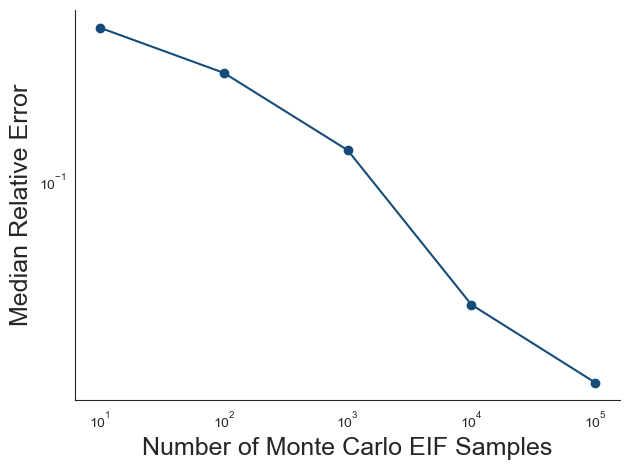

In [28]:
plt.plot(
    monte_eif_size, 
    monte_eif_errors, 
    label='Monte Carlo EIF', 
    color='#154c79',
    marker='o'
)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Median Relative Error', fontsize=18)
plt.xlabel('Number of Monte Carlo EIF Samples', fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig("./figures/monte_carlo_eif_samples_vs_error_expected_density.png")